In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

In [2]:
# Dataset can be found here: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?select=train.csv
# Assume that the dataset is placed in the same folder as this Jupyter Notebook

In [3]:
# DATA OVERVIEW

df = pd.read_csv("train.csv")

# Number of rows and columns
print(f"Original dataset consists of {df.shape[0]} rows and {df.shape[1]} columns")

# Number of distinct values per column
print("\nNumber of unique values per column:")
print(df.nunique().sort_values(ascending=False))

# Satisfaction class distribution
class_counts = df['satisfaction'].value_counts().sort_index()
total = class_counts.sum()
percentages = (class_counts / total * 100).round(2)

print("\nSatisfaction class distribution:")
print(f"Neutral/Dissatisfied: {class_counts[0]} ({percentages[0]}%)")
print(f"Satisfied:            {class_counts[1]} ({percentages[1]}%)")

df

Original dataset consists of 103904 rows and 25 columns

Number of unique values per column:
Unnamed: 0                           103904
id                                   103904
Flight Distance                        3802
Arrival Delay in Minutes                455
Departure Delay in Minutes              446
Age                                      75
Seat comfort                              6
Cleanliness                               6
Inflight service                          6
Checkin service                           6
Leg room service                          6
On-board service                          6
Inflight entertainment                    6
Food and drink                            6
Online boarding                           6
Gate location                             6
Ease of Online booking                    6
Departure/Arrival time convenient         6
Inflight wifi service                     6
Baggage handling                          5
Class                      

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,2,2,2,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,2,4,5,5,5,5,5,5,5,4,0,0.0,satisfied
103901,103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,4,1,5,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,1,1,1,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


Cleaned dataset consists of 103594 rows and 23 columns

Satisfaction class distribution:
Neutral/Dissatisfied: 58697 (56.66%)
Satisfied:            44897 (43.34%)


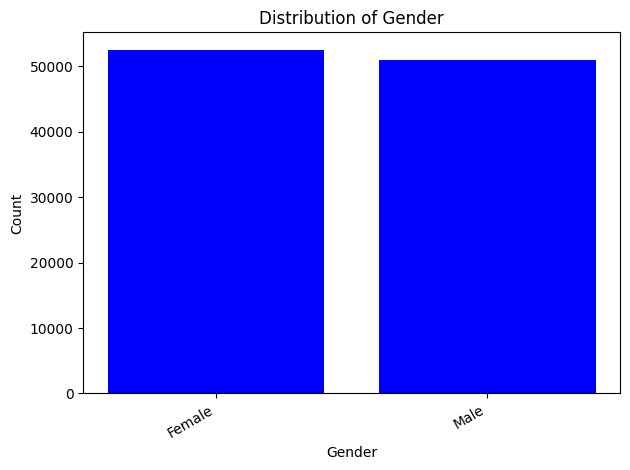

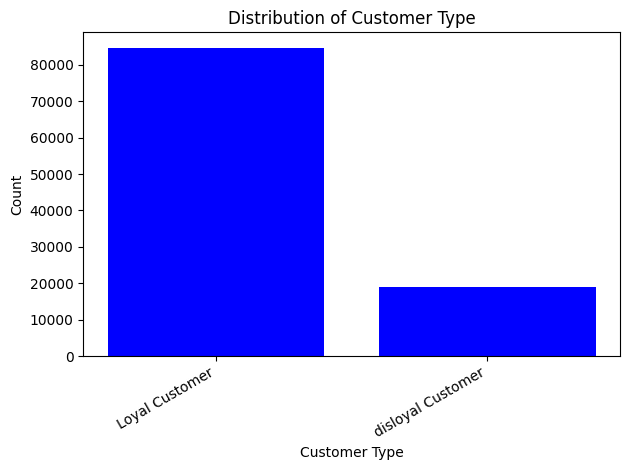

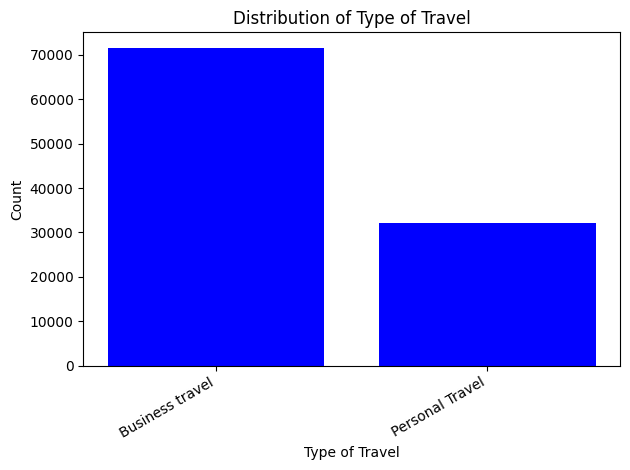

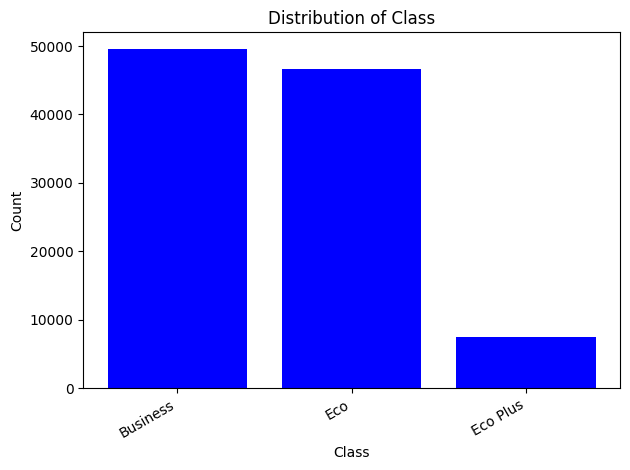

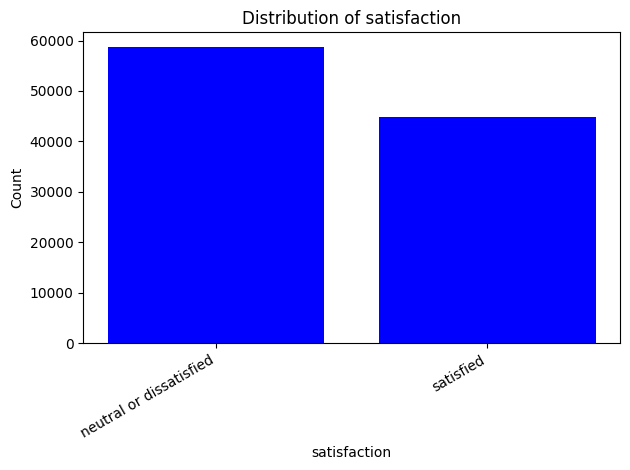

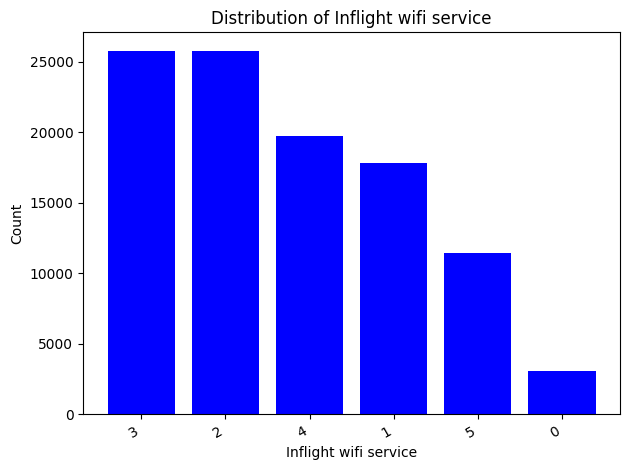

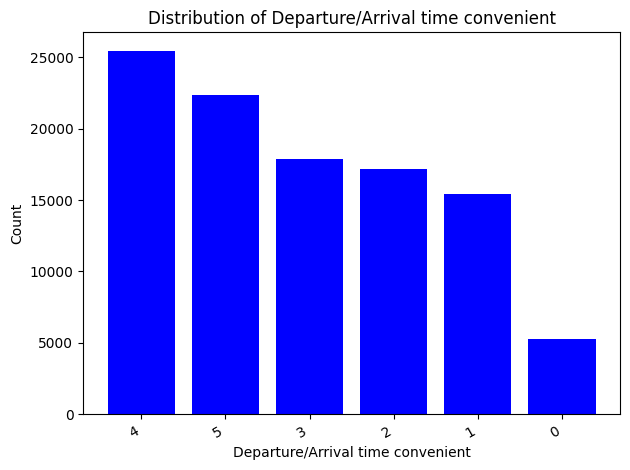

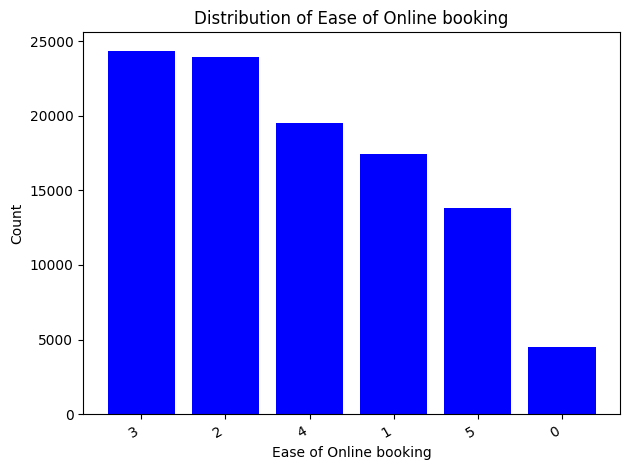

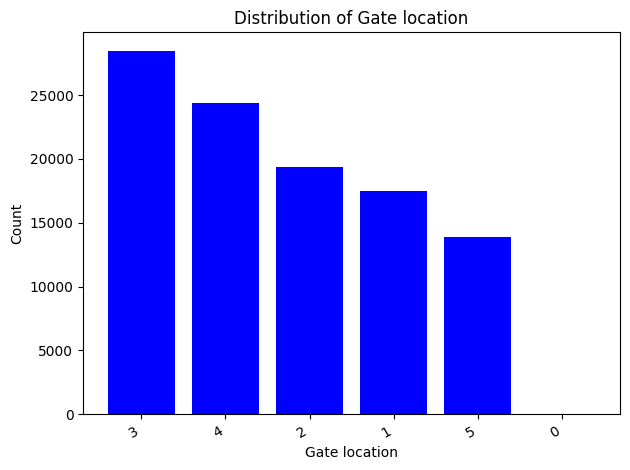

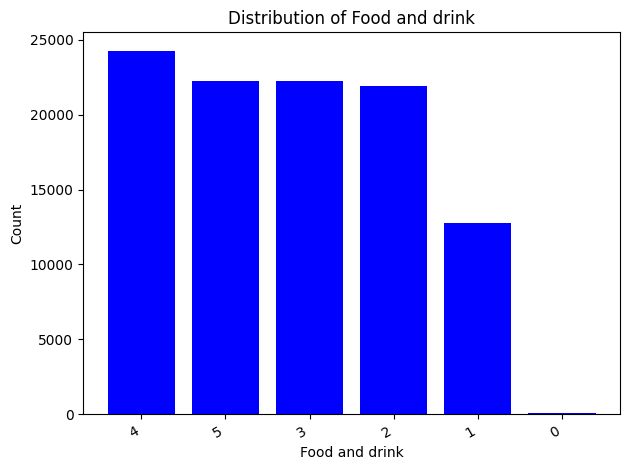

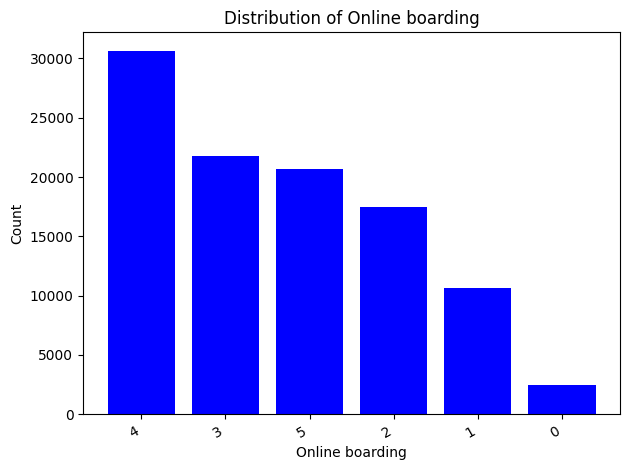

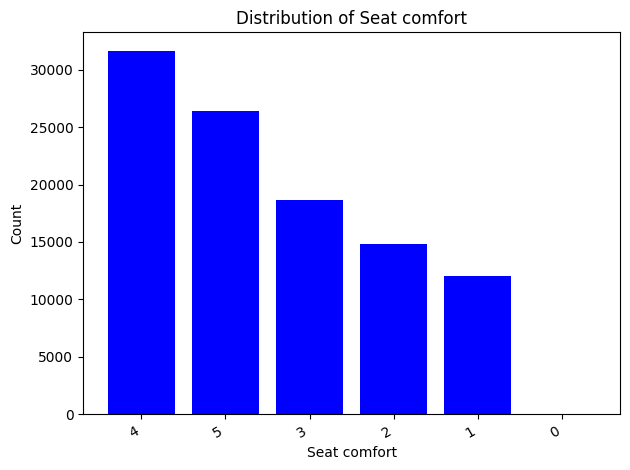

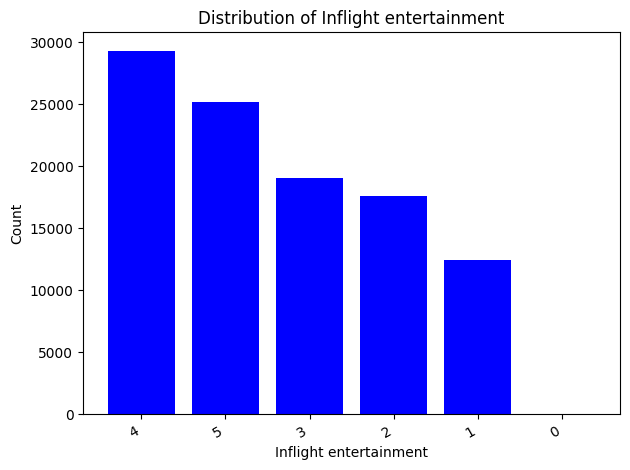

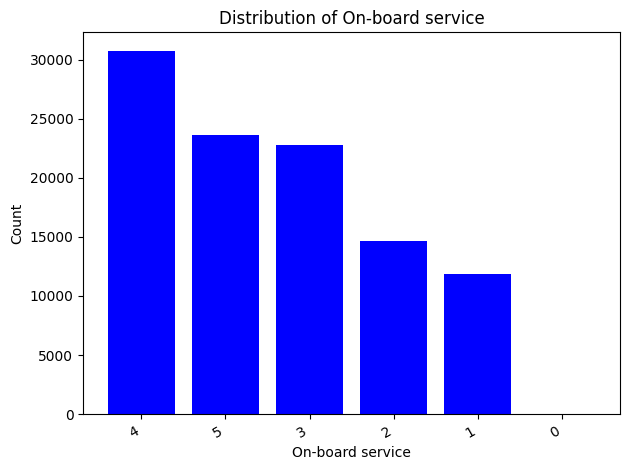

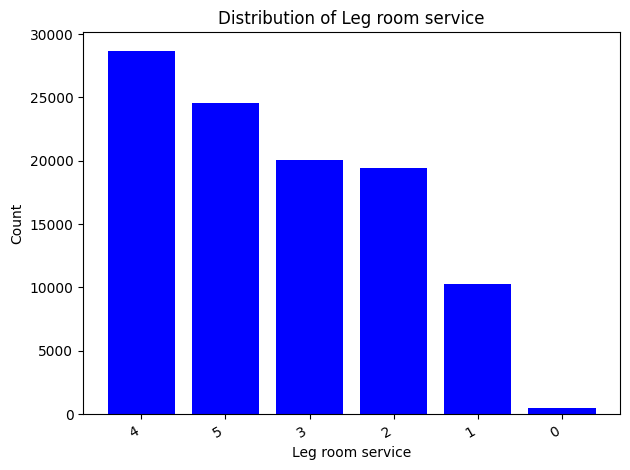

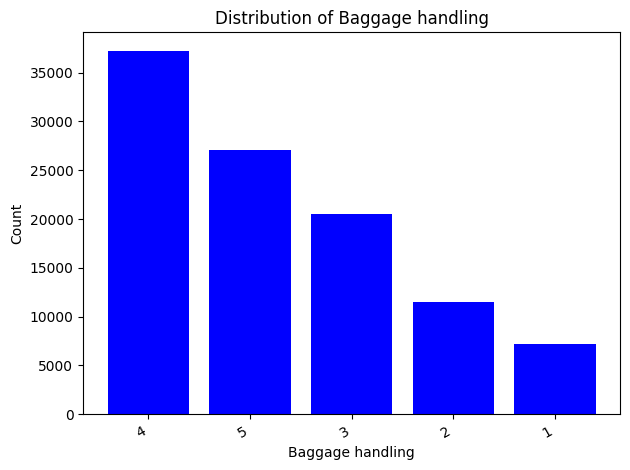

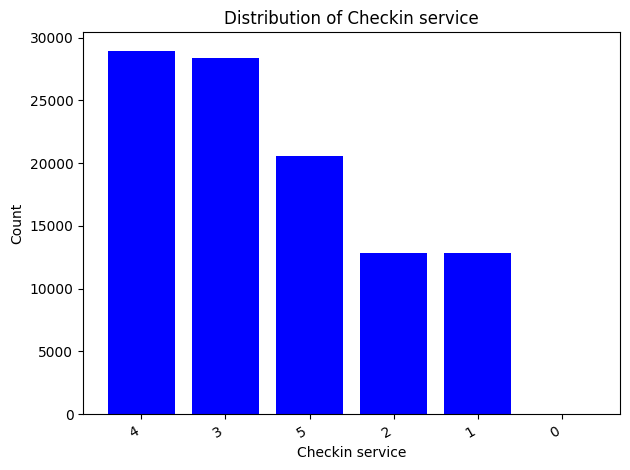

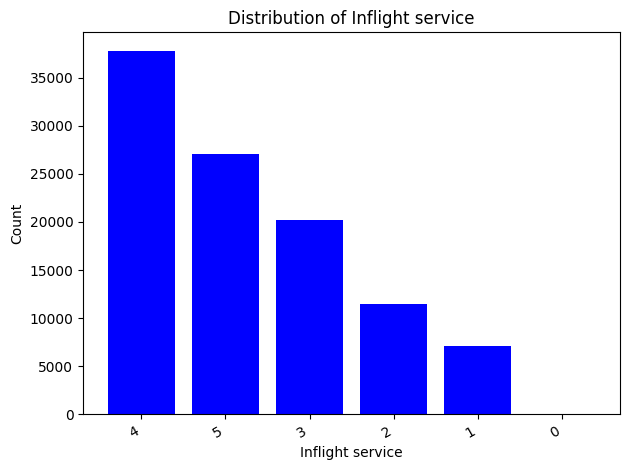

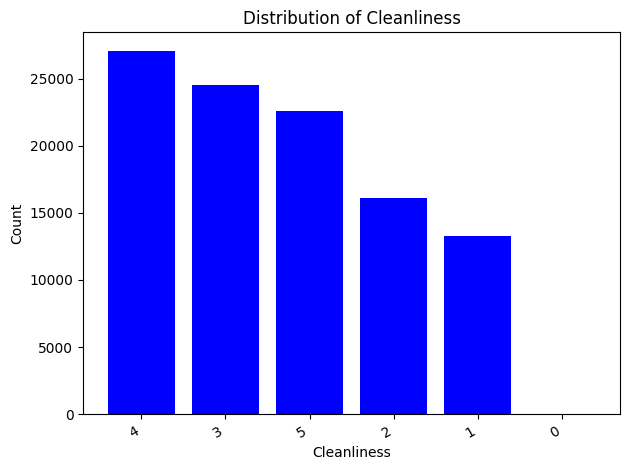

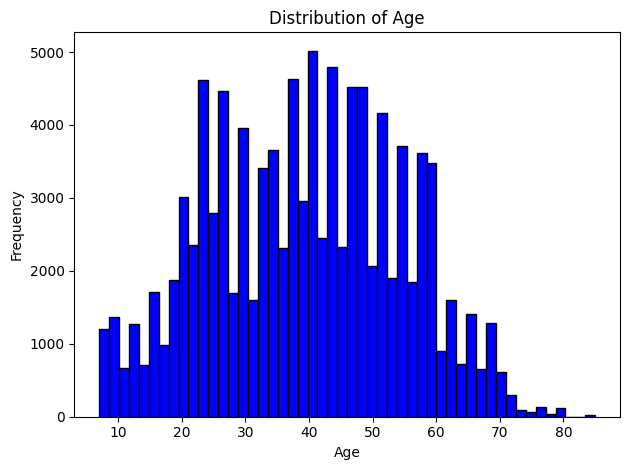

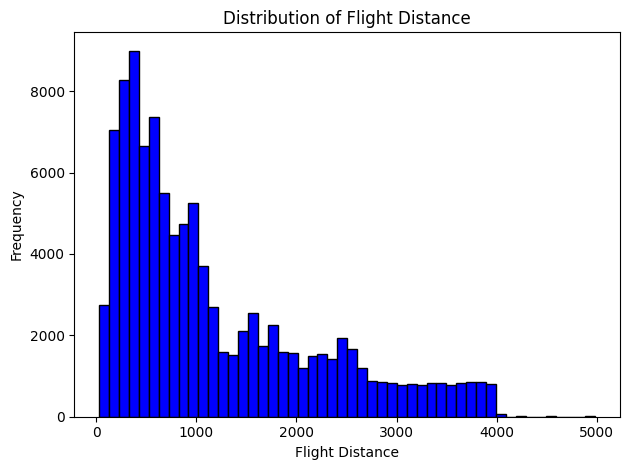

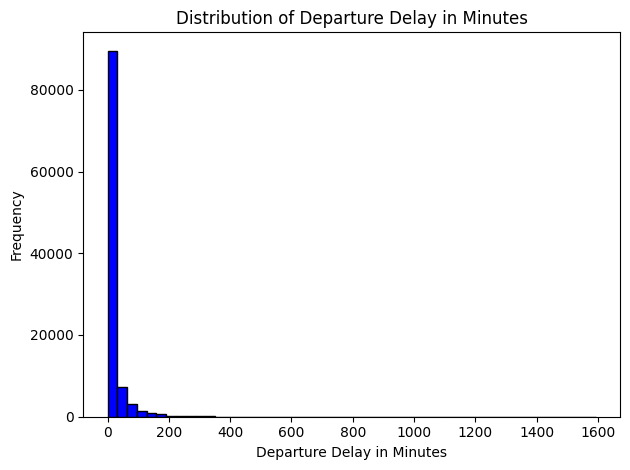

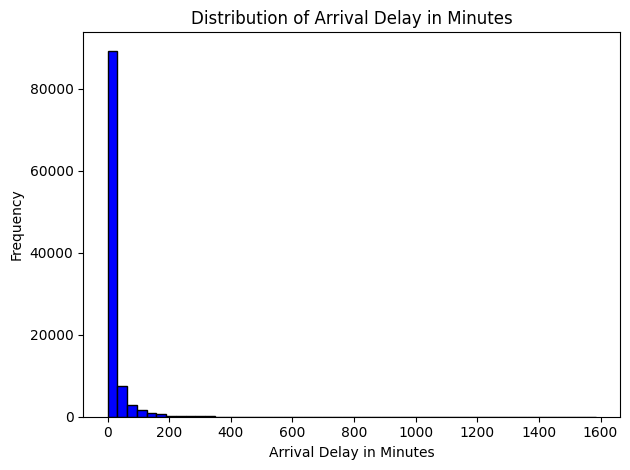

In [4]:
# CLEAN UP DATA + ATTRIBUTES DISTRIBUTION VISUALIZATION

# Drop id and unnamed column due to unique values and no meaning in helping the model learn
df_cleaned = df.drop(columns=[col for col in df.columns if col.strip() in ['id', 'Unnamed: 0']])

# Drop duplicates and remove rows with missing values
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned = df_cleaned.dropna()

print(f"Cleaned dataset consists of {df_cleaned.shape[0]} rows and {df_cleaned.shape[1]} columns")

# Satisfaction class distribution
class_counts = df_cleaned['satisfaction'].value_counts().sort_index()
total = class_counts.sum()
percentages = (class_counts / total * 100).round(2)

print("\nSatisfaction class distribution:")
print(f"Neutral/Dissatisfied: {class_counts[0]} ({percentages[0]}%)")
print(f"Satisfied:            {class_counts[1]} ({percentages[1]}%)")

# Attribute values distribution visualization
categorical_features = [
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class',
    'satisfaction',
]

service_features = [
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

for feature in categorical_features + service_features:
    if feature in df_cleaned.columns:
        counts = df_cleaned[feature].value_counts()
        plt.figure()
        plt.bar(counts.index.astype(str), counts.values, color='blue')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()
        plt.show()

numerical_features = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes'
]

for feature in numerical_features:
    if feature in df_cleaned.columns:
        plt.figure()
        plt.hist(df_cleaned[feature], bins=50, color='blue', edgecolor='black')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()


In [5]:
# ATTRIBUTES PREPROCESSING AND CONSTRUCTION

df_preprocessed = df_cleaned.copy()

# Binning
## Bin flight distance, departure and arrival delays into bins that are defined by most airlines
df_preprocessed['Flight Distance Category'] = pd.cut(
    df_preprocessed['Flight Distance'],
    bins=[-1, 699, 2999, float('inf')],
    labels=['Short-haul', 'Medium-haul', 'Long-haul']
)

df_preprocessed['Departure Delay Category'] = pd.cut(
    df_preprocessed['Departure Delay in Minutes'],
    bins=[-1, 14, 59, 179, float('inf')],
    labels=['On-time', 'Minor', 'Major', 'Severe']
)

df_preprocessed['Arrival Delay Category'] = pd.cut(
    df_preprocessed['Arrival Delay in Minutes'],
    bins=[-1, 14, 59, 179, float('inf')],
    labels=['On-time', 'Minor', 'Major', 'Severe']
)

## Bin age into age groups according to Smart Survey
## https://www.smartsurvey.com/survey-questions/demographics/age-groups
df_preprocessed['Age Category'] = pd.cut(
    df_preprocessed['Age'],
    bins=[-1, 17, 24, 34, 44, 54, 64, float('inf')],
    labels=['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
)

# One-hot encoding
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['Gender'], prefix='Gender', dtype=int)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['Customer Type'], prefix='Customer Type', dtype=int)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['Type of Travel'], prefix='Type of Travel', dtype=int)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['Class'], prefix='Class', dtype=int)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['Flight Distance Category'], prefix='Flight Distance Category', dtype=int)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['Departure Delay Category'], prefix='Departure Delay Category', dtype=int)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['Arrival Delay Category'], prefix='Arrival Delay Category', dtype=int)
df_preprocessed = pd.get_dummies(df_preprocessed, columns=['Age Category'], prefix='Age Category', dtype=int)

# New attributes & interaction terms
## Average service score

df_preprocessed['Average Service Score'] = df_preprocessed[service_features].mean(axis=1).round(2)

## Total delays experienced
df_preprocessed['Total Delay'] = (df_preprocessed['Departure Delay in Minutes'] + df_preprocessed['Arrival Delay in Minutes'])

## Delay ratio: normalize delay impact relative to flight length. Higher values suggest worse delay efficiency.
df_preprocessed['Delay Ratio'] = (
    df_preprocessed['Total Delay'] / df_preprocessed['Flight Distance'].replace(0, 1)
).round(4)

## Age x Flight distance: Combined burden of being older and traveling farther might increase dissatisfaction
df_preprocessed['Age x FlightDistance'] = (df_preprocessed['Age'] * df_preprocessed['Flight Distance'])

## Online booking x online boarding: Reflect the digital user experience, since more people are doing online check-in nowadays.
## Bad scores here imply digital frustration 
df_preprocessed['Booking_x_Boarding'] = (df_preprocessed['Ease of Online booking'] * df_preprocessed['Online boarding'])

## Checkin x Baggege: Capture ground service experience
df_preprocessed['Checkin_x_Baggage'] = df_preprocessed['Checkin service'] * df_preprocessed['Baggage handling']

## Comfort x Legroom: Physical seating experience -> cramped + hard = huge dissatisfaction
df_preprocessed['Comfort_x_Legroom'] = df_preprocessed['Seat comfort'] * df_preprocessed['Leg room service']

# Transform/rescaling/normalize some attributes
## Log-transform right-skewed attribute values:
log_skewed_cols = [
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Total Delay'
]

for col in log_skewed_cols:
    df_preprocessed[f'log1p_{col.replace(" ", "_")}'] = np.log1p(df_preprocessed[col])

df_preprocessed.drop(columns=[
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Total Delay'
], inplace=True)

## Rescaling numeric values that are not boolean
features_to_rescale = [
    'Age',
    'Delay Ratio',
    'Age x FlightDistance',
    'Booking_x_Boarding',
    'Checkin_x_Baggage',
    'Comfort_x_Legroom',
    'log1p_Flight_Distance',
    'log1p_Departure_Delay_in_Minutes',
    'log1p_Arrival_Delay_in_Minutes',
    'log1p_Total_Delay',
    'Average Service Score',
] + service_features

scaler = MinMaxScaler()
df_preprocessed[features_to_rescale] = scaler.fit_transform(df_preprocessed[features_to_rescale])

# Change the target columns to 0 (neutral or dissatisfied) and 1 (satisfied)
df_preprocessed['satisfaction'] = df_preprocessed['satisfaction'].map({
    'neutral or dissatisfied': 0,
    'satisfied': 1
})

print(f"Preprocessed dataset consists of {df_preprocessed.shape[0]} rows and {df_preprocessed.shape[1]} columns")

df_preprocessed

Preprocessed dataset consists of 103594 rows and 53 columns


,Age,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,Flight Distance Category_Short-haul,Flight Distance Category_Medium-haul,Flight Distance Category_Long-haul,Departure Delay Category_On-time,Departure Delay Category_Minor,Departure Delay Category_Major,Departure Delay Category_Severe,Arrival Delay Category_On-time,Arrival Delay Category_Minor,Arrival Delay Category_Major,Arrival Delay Category_Severe,Age Category_<18,Age Category_18-24,Age Category_25-34,Age Category_35-44,Age Category_45-54,Age Category_55-64,Age Category_65+,Average Service Score,Delay Ratio,Age x FlightDistance,Booking_x_Boarding,Checkin_x_Baggage,Comfort_x_Legroom,log1p_Flight_Distance,log1p_Departure_Delay_in_Minutes,log1p_Arrival_Delay_in_Minutes,log1p_Total_Delay
0,0.0769,0.6,0.8,0.6,0.2,1.0,0.6,1.0,1.0,0.8,0.6,0.75,0.8,1.0,1.0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0.7099,0.0089,0.0168,0.36,0.64,0.60,0.5284,0.4419,0.3996,0.4693
1,0.2308,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,0.2,1.0,0.50,0.2,0.8,0.2,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.3104,0.0028,0.0165,0.36,0.12,0.20,0.3958,0.0940,0.2641,0.2579
2,0.2436,0.4,0.4,0.4,0.4,1.0,1.0,1.0,1.0,0.8,0.6,0.75,0.8,0.8,1.0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.6718,0.0000,0.0879,0.40,0.64,0.60,0.7083,0.0000,0.0000,0.0000
3,0.2308,0.4,1.0,1.0,1.0,0.4,0.4,0.4,0.4,0.4,1.0,0.50,0.2,0.8,0.4,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.4911,0.0034,0.0410,0.40,0.12,0.40,0.5680,0.3370,0.3125,0.3776
4,0.6923,0.6,0.6,0.6,0.6,0.8,1.0,1.0,0.6,0.6,0.8,0.75,0.6,0.6,0.6,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.6183,0.0000,0.0380,0.60,0.48,0.80,0.3773,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,0.2051,0.4,0.2,0.4,0.6,0.4,0.4,0.4,0.4,0.6,0.2,0.75,0.4,0.6,0.4,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.2901,0.0015,0.0121,0.16,0.32,0.08,0.3560,0.1880,0.0000,0.1719
103900,0.5385,0.8,0.8,0.8,0.8,0.4,0.8,1.0,1.0,1.0,1.0,1.00,1.0,1.0,0.8,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.8372,0.0000,0.3437,0.64,1.00,1.00,0.8509,0.0000,0.0000,0.0000
103901,0.2949,0.2,0.2,0.2,0.6,0.8,0.2,1.0,0.8,0.6,0.4,0.75,1.0,1.0,0.8,0,0,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.5089,0.0010,0.1784,0.04,0.80,0.40,0.8187,0.2820,0.3675,0.3833
103902,0.1923,0.2,0.2,0.2,1.0,0.2,0.2,0.2,0.2,0.8,1.0,0.00,1.0,0.8,0.2,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.3104,0.0000,0.0649,0.04,0.20,0.20,0.6820,0.0000,0.0000,0.0000


In [6]:
# TRAINING, CROSS-VALIDATION, HYPERPARAMETER TUNING AND PRINTING RESULTS

# Construct input and output data
X = df_preprocessed.drop(columns='satisfaction')
y = df_preprocessed['satisfaction']

# Cross-validation with 5 folds
outer_cv = KFold(n_splits=10, shuffle=True, random_state=2025)

# Model configurations
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(max_iter=1000, solver='liblinear'),
        'param_grid': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'fit_intercept': [True, False]}
    },
    'K-Nearest Neighbors': {
        'estimator': KNeighborsClassifier(),
        'param_grid': {'n_neighbors': [7, 11, 15], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(random_state=2025),
        'param_grid': {'max_depth': [10, 20, 50, 100, 200]}
    }
}

# Model evaluation
def evaluate_model(name, estimator, param_grid):
    print(f"\n----- {name} -----")
    fold_results = []

    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid = GridSearchCV(estimator, param_grid, cv=3, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else y_pred

        metrics = {
            'Fold': i,
            'Best Params': grid.best_params_,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'ROC AUC': roc_auc_score(y_test, y_prob)
        }

        fold_results.append(metrics)

        print(f"\nFold {i} — Best Params: {grid.best_params_}")
        print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
        print(f"  Precision: {metrics['Precision']:.4f}")
        print(f"  Recall:    {metrics['Recall']:.4f}")
        print(f"  F1 Score:  {metrics['F1']:.4f}")
        print(f"  ROC AUC:   {metrics['ROC AUC']:.4f}")

    # Summary across folds
    df_metrics = pd.DataFrame(fold_results)
    avg = df_metrics[['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']].mean()
    print(f"\n{name} — Average Across Folds:")
    for metric, value in avg.items():
        print(f"{metric}: {value:.4f}")

for name, cfg in models.items():
    evaluate_model(name, cfg['estimator'], cfg['param_grid'])


----- Logistic Regression -----

Fold 1 — Best Params: {'C': 1, 'fit_intercept': False, 'penalty': 'l1'}
  Accuracy:  0.8749
  Precision: 0.8708
  Recall:    0.8380
  F1 Score:  0.8541
  ROC AUC:   0.9354

Fold 2 — Best Params: {'C': 1, 'fit_intercept': False, 'penalty': 'l1'}
  Accuracy:  0.8788
  Precision: 0.8725
  Recall:    0.8424
  F1 Score:  0.8572
  ROC AUC:   0.9407

Fold 3 — Best Params: {'C': 1, 'fit_intercept': True, 'penalty': 'l2'}
  Accuracy:  0.8834
  Precision: 0.8787
  Recall:    0.8469
  F1 Score:  0.8625
  ROC AUC:   0.9436

Fold 4 — Best Params: {'C': 10, 'fit_intercept': True, 'penalty': 'l1'}
  Accuracy:  0.8791
  Precision: 0.8743
  Recall:    0.8413
  F1 Score:  0.8575
  ROC AUC:   0.9361

Fold 5 — Best Params: {'C': 10, 'fit_intercept': False, 'penalty': 'l1'}
  Accuracy:  0.8838
  Precision: 0.8848
  Recall:    0.8428
  F1 Score:  0.8633
  ROC AUC:   0.9444

Fold 6 — Best Params: {'C': 1, 'fit_intercept': False, 'penalty': 'l1'}
  Accuracy:  0.8805
  Precisi